# Analyses of session part clusters


In [5]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [6]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go 

# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats


one = ONE(mode='remote')

## Get data

In [7]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [8]:
# Load old trial clsuters to get ballistic trials
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
trials_filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
# mouse_filename = str(results_path + 'cluster_per_mouse01-09-2025')
# old_mouse_clusters = pd.read_parquet(mouse_filename, engine='pyarrow')

In [9]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
# results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'

# trials_filename = str(results_path + 'cluster_per_trial_part_info03-12-2025')
# trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
# parts_filename = str(results_path + 'cluster_per_session_part03-12-2025')
# parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

# trials_filename = str(results_path + 'cluster_per_trial_part_info03-19-2025')
# trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
# parts_filename = str(results_path + 'cluster_per_session_part03-19-2025')
# parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

trials_filename = str(results_path + 'cluster_per_trial_part_info03-21-2025')
trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
parts_filename = str(results_path + 'cluster_per_session_part03-21-2025')
parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

# # No UMAP
# parts_filename = str(results_path + 'cluster_per_session_part_noUMAP')
# parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

## UMAP embedding per mouse with multiple sessions

In [10]:
df = parts_clusters[['sample', 'mouse_name', 'part_cluster', 'UMAP1', 'UMAP2']].drop_duplicates()
df['part'] = df['sample'].str.split().str[1:2].str.join('')
df = df.loc[df['part']=='0.0']

In [11]:
session_num = df.groupby(['mouse_name'])['part'].count()

In [12]:
use_data = df[['mouse_name', 'UMAP1', 'UMAP2', 'part_cluster']].merge(session_num.reset_index(), on='mouse_name')


/tmp/ipykernel_11242/3172375232.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.5, 1.05))


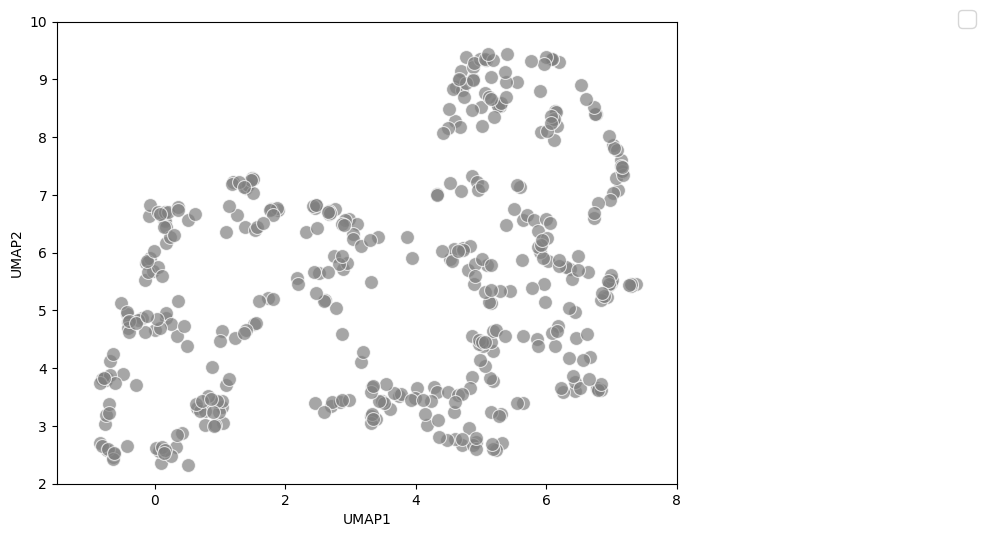

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
data = parts_clusters[['sample', 'mouse_name', 'part_cluster', 'UMAP1', 'UMAP2']].drop_duplicates()
data['part'] = data['sample'].str.split().str[1:2].str.join('')
sns.scatterplot(x='UMAP1', y='UMAP2', data=data, 
                alpha=0.7, s=100, color='grey')
plt.ylim([2, 10])
plt.xlim([-1.5, 8])
plt.legend(bbox_to_anchor=(1.5, 1.05))

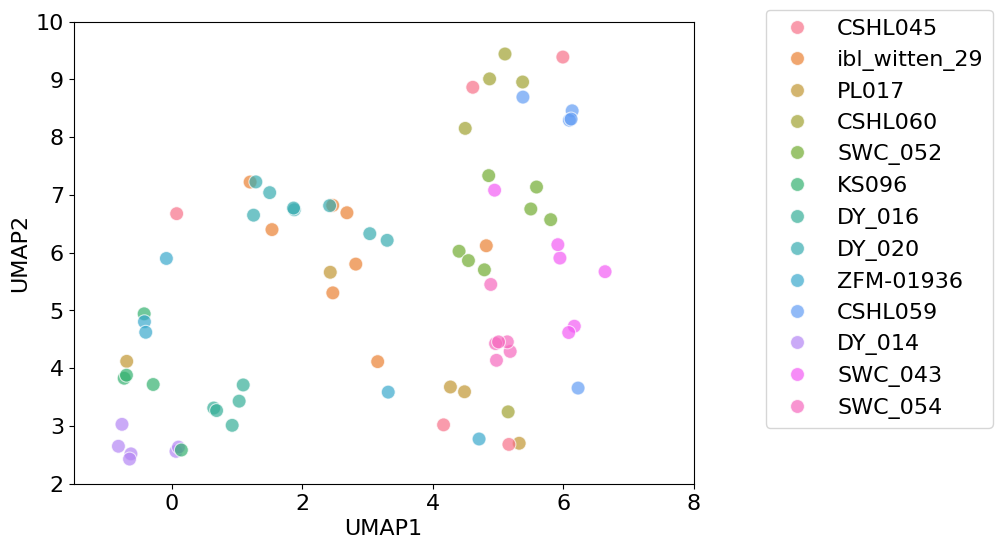

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
sns.scatterplot(x='UMAP1', y='UMAP2', data=use_data.loc[(use_data['part']>4)], 
                alpha=0.7, hue='mouse_name', s=100)
plt.ylim([2, 10])
plt.xlim([-1.5, 8])
plt.legend(bbox_to_anchor=(1.5, 1.05))

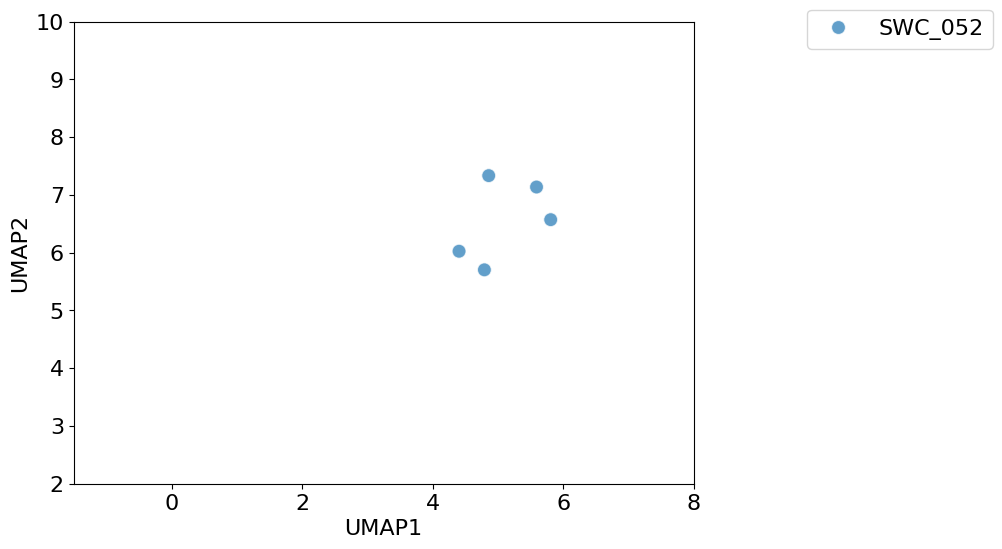

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
sns.scatterplot(x='UMAP1', y='UMAP2', data=use_data.loc[(use_data['part']>4) & 
                                                        (use_data['mouse_name']=='SWC_052')][:5], 
                alpha=0.7, hue='mouse_name', s=100, )
plt.ylim([2, 10])
plt.xlim([-1.5, 8])
plt.legend(bbox_to_anchor=(1.5, 1.05))



In [16]:
parts_clusters['part_cluster'] = [1 if x == 0 else 0 if x == 1 else x for x in parts_clusters['part_cluster']]

# Performance for sessions in use

Text(0, 0.5, 'Number of sessions')

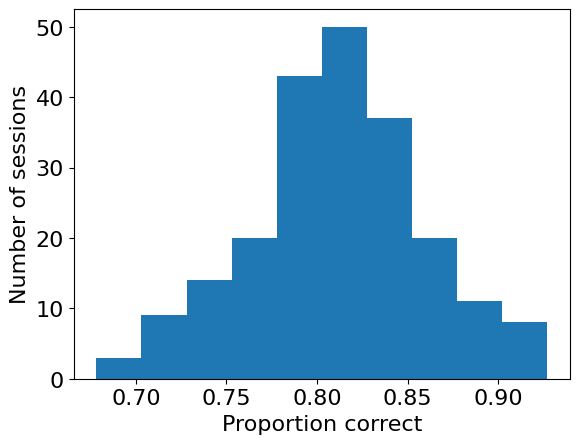

In [17]:
perf_dist = trial_clusters.groupby(['session'])['feedback'].mean().reset_index()
plt.hist(perf_dist['feedback'])
plt.xlabel('Proportion correct')
plt.ylabel('Number of sessions')

## Plot parts cluster features

In [10]:
mean_cluster_parts = pd.DataFrame(parts_clusters.groupby(['part_cluster', 'cluster'])['relative_frequency'].mean()).reset_index()


In [11]:

plt_vars = ['0', '1', '2', '3', '4', '5', '6'] 

unique_clusters = [0, 1, 2, 3, 4, 5, 6]
new_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}

mapping = {
    cluster: label
    for cluster, label in zip(unique_clusters, plt_vars)
}
mapping
replace_func = np.vectorize(mapping.get)

replace_func = np.vectorize(new_dict.get)
mean_cluster_parts['new_clusters'] = mean_cluster_parts['cluster'].copy()
mean_cluster_parts['new_clusters'] = replace_func(mean_cluster_parts['cluster'])


In [12]:
mean_cluster_parts['label'] = mean_cluster_parts['cluster'].copy()
mean_cluster_parts['label'] = replace_func(mean_cluster_parts['label'])

mean_cluster_parts.sort_values(by='label')

# Custom order (array) for the 'name' column
custom_order = ['Right ballistic','Accurate, long pre-quiescence','Long reaction', 'Left ballistic',
            'Left non-ballistic','Right non-ballistic'] 
custom_order = ['0', '1', '2', '3', '4', '5', '6']

# Convert the 'name' column to a categorical type with the specified order
mean_cluster_parts['label'] = pd.Categorical(mean_cluster_parts['label'], categories=custom_order, ordered=True)


In [15]:
# Choose a Seaborn palette and convert it to HEX format
palette = sns.light_palette("seagreen", 3, as_cmap=False)
colors = [f'rgba({int(r*255)},{int(g*255)},{int(b*255)},.6)' for r, g, b in palette]  # Adjust transparency if needed

# Create the figure
fig = go.Figure()

# Add traces with custom colors and dark grey contours
for i in range(3):  # Assuming 3 clusters
    fig.add_trace(go.Scatterpolar(
        r=pd.Series(mean_cluster_parts.sort_values(by='new_clusters')
                    .loc[mean_cluster_parts['part_cluster'] == i, 'relative_frequency'].values),
        theta=plt_vars,
        fill='toself',
        name=f'Fingerprint {i}',
        line=dict(color='darkgrey', width=2),  # Dark grey contour
        fillcolor=colors[i]  # Assign Seaborn fill colors
    ))

# Update layout
fig.update_layout(
    polar=dict(
        angularaxis=dict(tickfont=dict(size=16)),  # Set font size for theta labels
        radialaxis=dict(visible=True, tickfont=dict(size=16))
    ),
    showlegend=True
)

fig.show()

## Merge trial info and mouse clusters

In [16]:
part_trials_df = parts_clusters.merge(trial_clusters[['mouse_name', 'sample', 'reaction', 'response', 
                                                      'elongation', 'feedback', 'ballistic', 
                                                      'choice', 'side', 'contrast', 'block']], on=['mouse_name', 'sample'])
# new_df = pd.DataFrame(new_df.groupby(['mouse_name', 'mouse_cluster'])['reaction', 'response', 'elongation', 'correct', 'ballistic'].mean()).reset_index()

/tmp/ipykernel_11242/1638103532.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='part_cluster', y='trial_id', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
/tmp/ipykernel_11242/1638103532.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


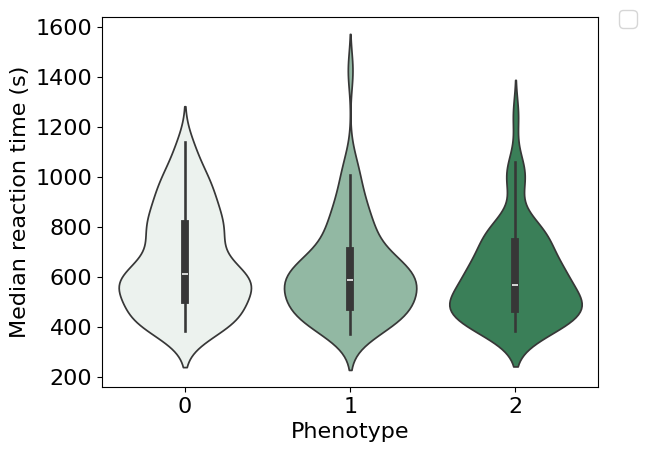

In [100]:
# part_trials_df = trial_clusters.merge(parts_clusters[['mouse_name', 'part_cluster']])
plt.rcParams.update({'font.size': 16})

new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['trial_id']].count()).reset_index()
new_df['trial_id'] = new_df['trial_id'] * 2
sns.violinplot(x='part_cluster', y='trial_id', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='part_cluster', y='trial_id', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.ylim([0, 1])
plt.title('')
plt.ylabel('Median reaction time (s)')
plt.xlabel('Phenotype')
# plt.savefig(file_path+'reaction_mouse.svg', format="svg")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


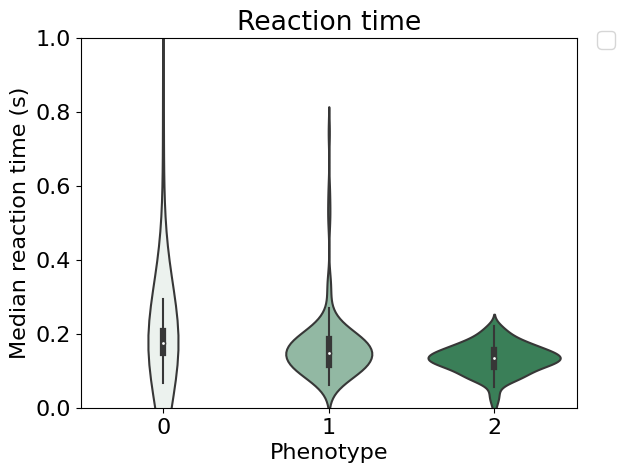

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


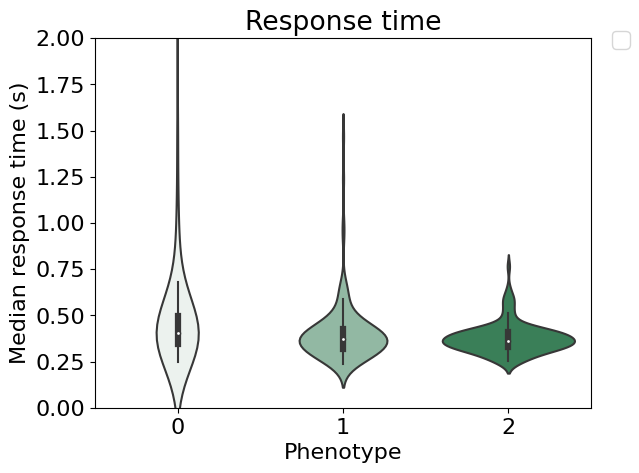

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


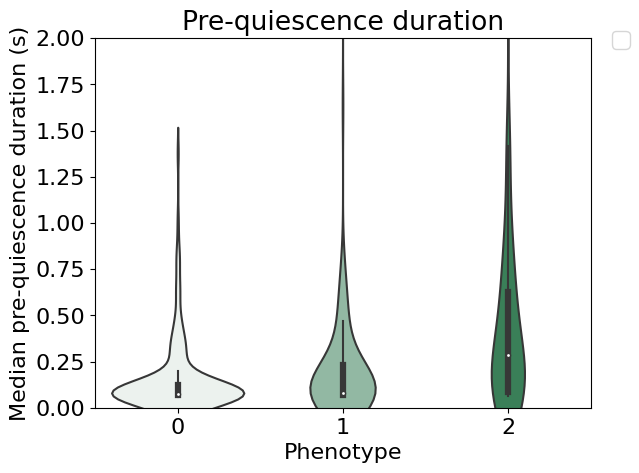

In [12]:
# part_trials_df = trial_clusters.merge(parts_clusters[['mouse_name', 'part_cluster']])
plt.rcParams.update({'font.size': 16})

new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['reaction', 'response', 
                                                                                          'elongation']].median()).reset_index()
sns.violinplot(x='part_cluster', y='reaction', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylim([0, 1])
plt.title('Reaction time')
plt.ylabel('Median reaction time (s)')
plt.xlabel('Phenotype')
# plt.savefig(file_path+'reaction_mouse.svg', format="svg")

plt.show()

sns.violinplot(x='part_cluster', y='response', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Median response time (s)')
plt.ylim([0, 2])
# plt.savefig(file_path+'response_mouse.svg', format="svg")

plt.xlabel('Phenotype')
plt.show()

sns.violinplot(x='part_cluster', y='elongation', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Median pre-quiescence duration (s)')
# plt.savefig(file_path+'elongation_mouse.svg', format="svg")
plt.ylim([0, 2])
plt.xlabel('Phenotype')
plt.show()


                    sum_sq     df         F   PR(>F)
part_cluster  2.677095e+05    1.0  7.111421  0.00795
Residual      1.611206e+07  428.0       NaN      NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper  reject
------------------------------------------------------
     0      1 -40.2242 0.1713  -92.8281 12.3797  False
     0      2 -59.5329 0.0259 -113.3351 -5.7307   True
     1      2 -19.3088 0.7064  -76.4422 37.8247  False
------------------------------------------------------


/tmp/ipykernel_11242/1180564453.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='part_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))


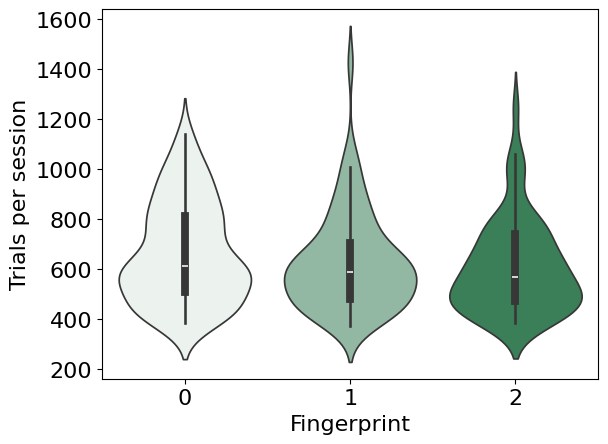

P-value for KW: 0.030
          0         1         2
0  1.000000  0.303531  0.029353
1  0.303531  1.000000  1.000000
2  0.029353  1.000000  1.000000


In [104]:
var_1 = 'trial_id ~ part_cluster'
var = 'trial_id'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = new_df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'part_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['part_cluster'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
sns.violinplot(x='part_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 1])
plt.xlabel('Fingerprint')
plt.ylabel('Trials per session')
# plt.ylabel('Training time (sessions)')
# plt.savefig(file_path+'training_time.svg', format="svg")

plt.show()

group_1 = new_df.loc[new_df['part_cluster']==0, var]
group_2 = new_df.loc[new_df['part_cluster']==1, var]
group_3 = new_df.loc[new_df['part_cluster']==2, var]


stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(new_df.dropna(), val_col=var, group_col='part_cluster', p_adjust='bonferroni')
print(posthoc)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


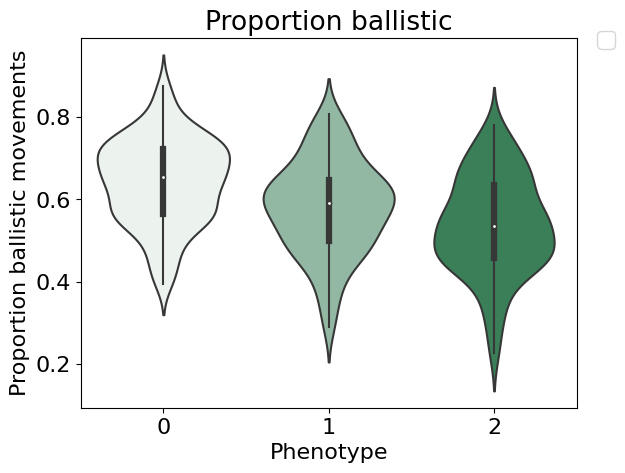

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


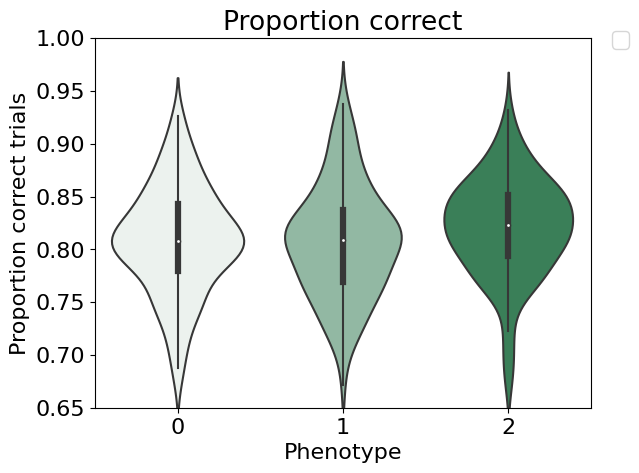

In [14]:

new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['feedback', 'ballistic',
                                                                                           'contrast', 'block']].mean()).reset_index()

sns.violinplot(x='part_cluster', y='ballistic', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic movements')
# plt.savefig(file_path+'ballistic_mouse.svg', format="svg")

plt.xlabel('Phenotype')
plt.show()

sns.violinplot(x='part_cluster', y='feedback', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylim([.65,1])
plt.title('Proportion correct')
plt.ylabel('Proportion correct trials')
# plt.savefig(file_path+'correct_mouse.svg', format="svg")

plt.xlabel('Phenotype')
# plt.ylim([.5, 1])
plt.show()

# sns.barplot(x='part_cluster', y='contrast', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Contrast')
# plt.ylabel('Contrast')
# # plt.savefig(file_path+'correct_mouse.svg', format="svg")

# plt.xlabel('Cluster')
# plt.ylim([.5, 1])
# plt.show()

# sns.violinplot(x='part_cluster', y='block', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Block probability')
# plt.ylabel('lock probability')
# # plt.savefig(file_path+'ballistic_mouse.svg', format="svg")
# plt.xlabel('Cluster')
# plt.show()



## Plot states per cluster

In [22]:
part_trials_df = parts_clusters.merge(trial_clusters, on=['mouse_name', 'sample', 'cluster'])

In [18]:
from matplotlib.colors import LinearSegmentedColormap

# Load color palette
colors = sns.cubehelix_palette(3,as_cmap=False)
colors = sns.color_palette("viridis", 3)

# Function to create a colormap from a base color (white to color)
def create_shaded_cmap(base_color, name='custom_cmap'):
    cdict = {
        'red':   [[0.0, 1.0, 1.0], [1.0, base_color[0], base_color[0]]],
        'green': [[0.0, 1.0, 1.0], [1.0, base_color[1], base_color[1]]],
        'blue':  [[0.0, 1.0, 1.0], [1.0, base_color[2], base_color[2]]]
    }
    return LinearSegmentedColormap(name, cdict)

In [19]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)
# lick_states = replace_lick(use_sequences)

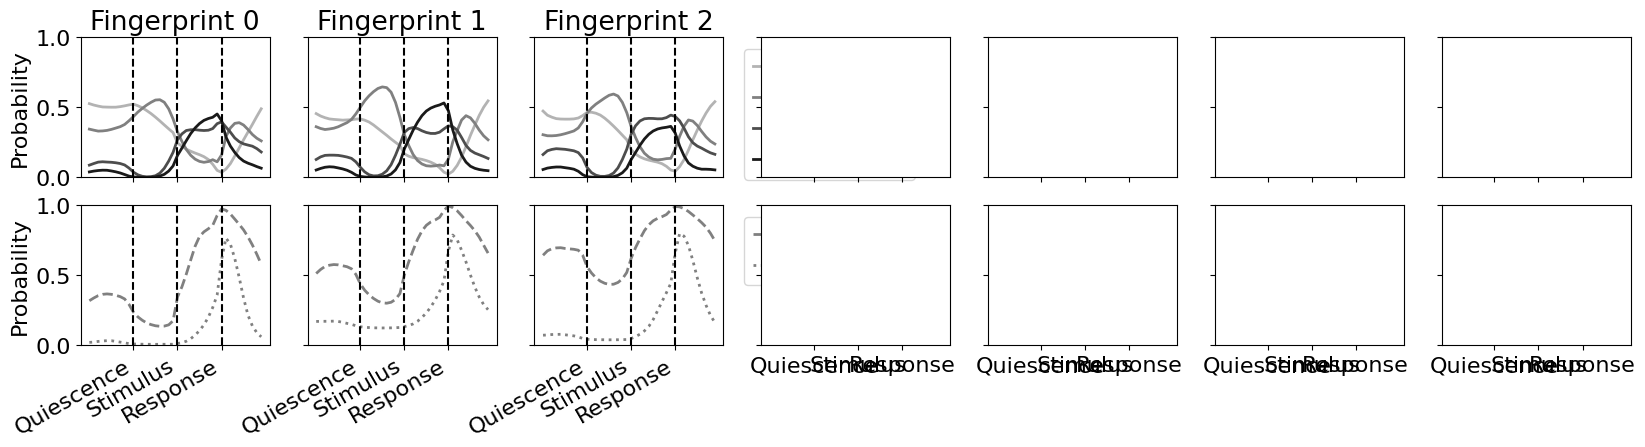

In [21]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

fig, axs = plt.subplots(2, 7, sharex=True, sharey=True, figsize=(20, 4)) # len(parts_clusters['part_cluster'].unique())
plt.rcParams.update({'font.size': 16})

for c, cluster in enumerate([0, 1, 2]):
    cluster_data = part_trials_df.loc[part_trials_df['part_cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])

    num_lines = 4
    colors = [str(1- 0.6 * (i / (num_lines - 1))-.3) for i in range(num_lines)]  # Light to dark gray
    axs[0, c].set_prop_cycle(color=colors)
    axs[0, c].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'], linewidth=2)
    axs[1, c].plot(all_stacked[4:5, :].T, label='Whisking', color='grey', linewidth=2, linestyle='--')
    axs[1, c].plot(all_stacked[5:6, :].T, label='Licking', color='grey', linewidth=2, linestyle=':')

    axs[0, c].axvline(x=10, color='k', linestyle='--')
    axs[0, c].axvline(x=20, color='k', linestyle='--')
    axs[0, c].axvline(x=30, color='k', linestyle='--')
    axs[1, c].axvline(x=10, color='k', linestyle='--')
    axs[1, c].axvline(x=20, color='k', linestyle='--')
    axs[1, c].axvline(x=30, color='k', linestyle='--')
    # axs[2, c].axvline(x=10, color='k', linestyle='--')
    # axs[2, c].axvline(x=20, color='k', linestyle='--')
    # axs[2, c].axvline(x=30, color='k', linestyle='--')
    axs[0, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[1, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[2, c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[0, c].set_title('Fingerprint ' +str(cluster))
    axs[0, c].set_ylim([0, 0.7])
    axs[1, c].set_ylim([0, 1])
    # axs[2, c].set_ylim([0, 0.8])

axs[0, 0].set_ylabel('Probability')
axs[1, 0].set_ylabel('Probability')
# axs[2, 0].set_ylabel('Probability')

axs[0, 2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[1, 2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axs[2, 2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.tight_layout()
# plt.savefig(file_path+'phenotype_states.svg', format="svg")


## Cluster assignment entropy

In [35]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'entropy03-21-2025')
entropy = pd.read_parquet(filename, engine='pyarrow')

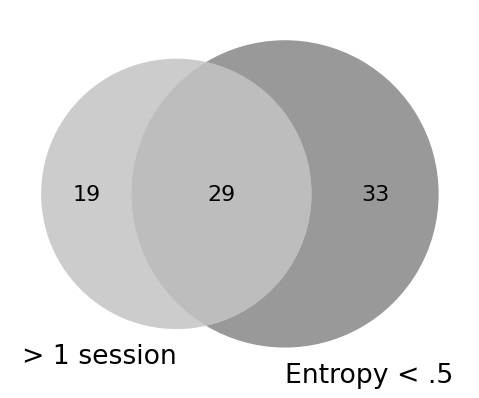

In [19]:
from matplotlib_venn import venn2

set1 = set(list(entropy.loc[(entropy['session_len']>1) & (entropy['variable']=='True'), 'mouse_name']))
set2 = set(list(entropy.loc[(entropy['value']<.3), 'mouse_name']))

venn2([set1, set2], ('> 1 session', 'Entropy < .5'), set_colors=("grey", "black"))

plt.show()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



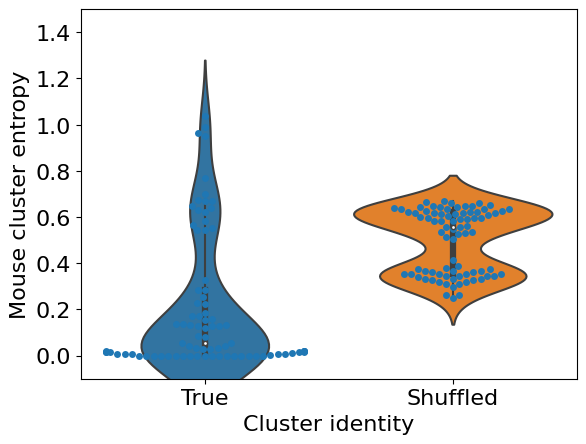

In [28]:
sns.swarmplot(x='variable', y='value', data=entropy)
sns.violinplot(x='variable', y='value', data=entropy)
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')

## Load learning data

In [23]:
# new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['feedback', 'ballistic',
#                                                                                            'contrast', 'block']].mean()).reset_index()
new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['feedback',
                                                                                           'contrast', 'block']].mean()).reset_index()
# new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['reaction', 'response', 
#                                                                                           'elongation']].median()).reset_index()

In [24]:
data_path = prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()
df = new_df.merge(learning_times, on='mouse_name')

/tmp/ipykernel_11242/2576267361.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [25]:
data_path = prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

In [26]:
a = df[['mouse_name', 'training_time']].merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

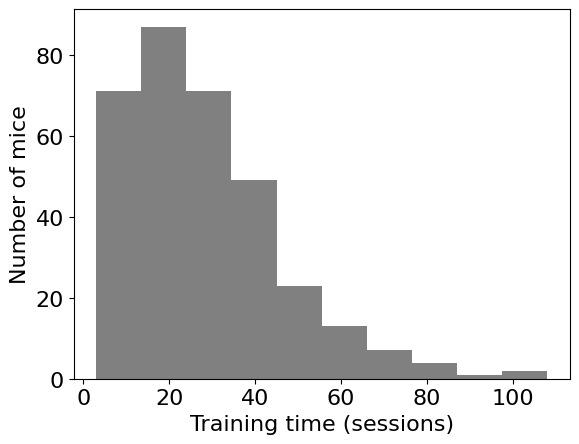

In [27]:
plt.rcParams.update({'font.size': 16})
plt.hist(full_learning['training_time'], color='grey')
plt.xlabel('Training time (sessions)')
plt.ylabel('Number of mice')
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/'
# plt.savefig(save_path+'histogram_training_time.svg', format="svg")

In [28]:
filter_mice = entropy.loc[(entropy['variable']=='True') & (entropy['session_len']>1) & (entropy['value']<.5), 'mouse_name']

## Correlation entropy and performance

In [74]:
perf = pd.DataFrame(part_trials_df.groupby(['mouse_name'])[['feedback','contrast', 'block']].mean()).reset_index()

(0.12415207718611992, 0.400495182603326)

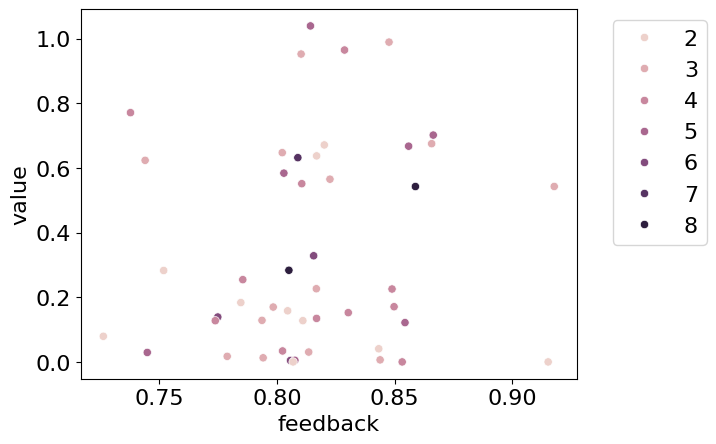

In [92]:
mouse_perf = pd.DataFrame(perf.groupby(['mouse_name'])['feedback'].mean()).reset_index()
perf_ent = mouse_perf.merge(entropy, on=['mouse_name'])

use_data = perf_ent.loc[(perf_ent['variable']=='True') & (perf_ent['session_len']>1)]
sns.scatterplot(x='feedback', y='value', data=use_data, hue='session_len')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
res = stats.pearsonr(use_data['value'], use_data['feedback'])
res

## Correlate entropy and training time

In [60]:
use_ent = entropy.loc[(entropy['variable']=='True') & (entropy['session_len']>1)]

In [61]:
ines = use_ent.merge(full_learning, on='mouse_name')

(0.21008420490705665, 0.15180366166946127)

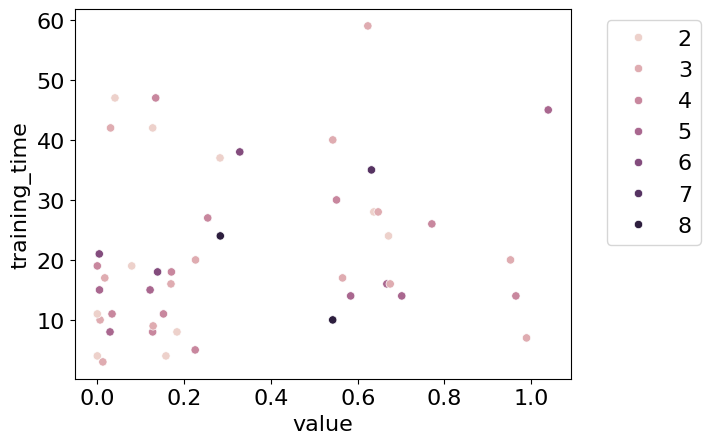

In [62]:
sns.scatterplot(x='value', y='training_time', data=ines, hue='session_len')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
from scipy import stats

res = stats.pearsonr(ines['value'], ines['training_time'])
res

In [32]:
ines['ent'] = ines['value']
ines.loc[ines['value']<=.5, 'ent'] = 0
ines.loc[ines['value']>.5, 'ent'] = 1

               sum_sq    df         F    PR(>F)
ent        337.568056   1.0  1.899293  0.174825
Residual  8175.744444  46.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0   5.4778 0.1748 -2.523 13.4785  False
---------------------------------------------------
P-value for KW: 0.141
          0.0       1.0
0.0  1.000000  0.141428
1.0  0.141428  1.000000


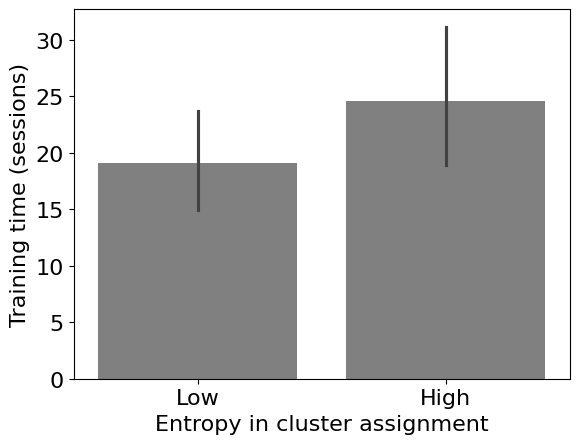

In [33]:
df = ines.loc[ines['session_len']>1]
var_1 = 'training_time ~ ent'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['ent'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
# sns.scatterplot(x='ent', y=var, data=data, color='black')
sns.barplot(x='ent', y='training_time', data=data, color='grey')
plt.xticks([0, 1], ['Low', 'High'])
plt.xlabel('Entropy in cluster assignment')
plt.ylabel('Training time (sessions)')
# # plt.savefig(file_path+'training_time.svg', format="svg")

# plt.show()

group_1 = df.loc[df['ent']==0, var]
group_2 = df.loc[df['ent']==1, var]

stat, p_value = stats.kruskal(group_1, group_2)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='ent', p_adjust='bonferroni')
print(posthoc)


## Training time and fingerprints

                    sum_sq     df         F    PR(>F)
part_cluster    397.524106    1.0  2.194374  0.139251
Residual      77534.792173  428.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   2.0422 0.3821 -1.5833  5.6677  False
     0      2  -2.7059 0.2002  -6.414  1.0022  False
     1      2  -4.7481 0.0133 -8.6858 -0.8104   True
----------------------------------------------------


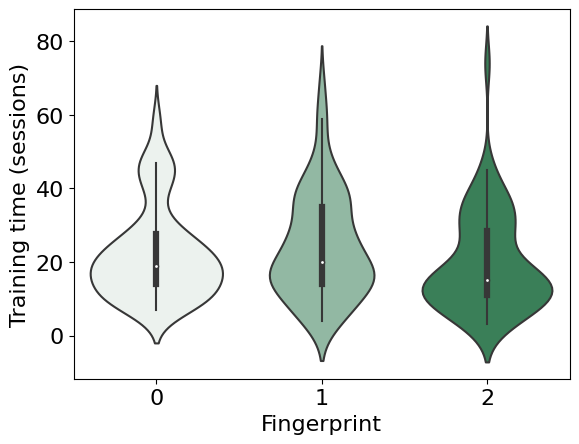

P-value for KW: 0.011
          0         1         2
0  1.000000  0.994641  0.090458
1  0.994641  1.000000  0.009984
2  0.090458  0.009984  1.000000


In [27]:
df = new_df.merge(full_learning, on='mouse_name')

var_1 = 'training_time ~ part_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'part_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['part_cluster'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
sns.violinplot(x='part_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 80])
plt.xlabel('Fingerprint')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
# plt.savefig(file_path+'training_time.svg', format="svg")

plt.show()

group_1 = df.loc[df['part_cluster']==0, var]
group_2 = df.loc[df['part_cluster']==1, var]
group_3 = df.loc[df['part_cluster']==2, var]


stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='part_cluster', p_adjust='bonferroni')
print(posthoc)


# Analyses per quartile

In [35]:
learning_times = full_learning.copy()
quartiles = learning_times['training_time'].quantile(q=[0.25, 0.5, 0.75])
# quartiles = learning_times['training_time'].quantile(q=[0.33, 0.66])

In [36]:
learning_times['quartile'] = learning_times['training_time']*np.nan
learning_times.loc[learning_times['training_time']<=quartiles[0.25], 'quartile']= 1
learning_times.loc[(learning_times['training_time']>quartiles[0.25]) & (learning_times['training_time']<=quartiles[0.50]), 'quartile']= 2
learning_times.loc[(learning_times['training_time']>quartiles[0.50]) & (learning_times['training_time']<=quartiles[0.75]), 'quartile']= 3
learning_times.loc[learning_times['training_time']>quartiles[0.75], 'quartile']= 4

In [10]:
learning_times['quartile'] = learning_times['training_time']*np.nan
learning_times.loc[learning_times['training_time']<=quartiles[0.33], 'quartile']= 1
learning_times.loc[(learning_times['training_time']>quartiles[0.33]) & (learning_times['training_time']<=quartiles[0.66]), 'quartile']= 2
learning_times.loc[learning_times['training_time']>quartiles[0.66], 'quartile']= 3

KeyError: 0.33

In [37]:
df = new_df.merge(learning_times[['mouse_name', 'training_time', 'quartile']], on='mouse_name')

In [39]:
sns.violinplot(x='quartile', y='reaction', data=df)
plt.show()
sns.barplot(x='quartile', y='reaction', data=df)
plt.show()
sns.violinplot(x='quartile', y='response', data=df)
plt.show()
sns.barplot(x='quartile', y='response', data=df)
plt.show()
sns.violinplot(x='quartile', y='elongation', data=df)
plt.show()
sns.barplot(x='quartile', y='elongation', data=df)
plt.show()


ValueError: Could not interpret input 'reaction'

### Plot state use per quartile

In [ ]:
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()


In [40]:
part_trials_df = parts_clusters.merge(trial_clusters, on=['mouse_name', 'sample', 'cluster'])

In [50]:
# use_states = parts_clusters.merge(learning_times[['mouse_name',  'quartile']], on='mouse_name')
use_parts_trials = part_trials_df.merge(learning_times[['mouse_name',  'quartile']], on='mouse_name')
# use_parts_trials = use_parts_trials.loc[use_parts_trials['mouse_name'].isin(filter_mice)].dropna()

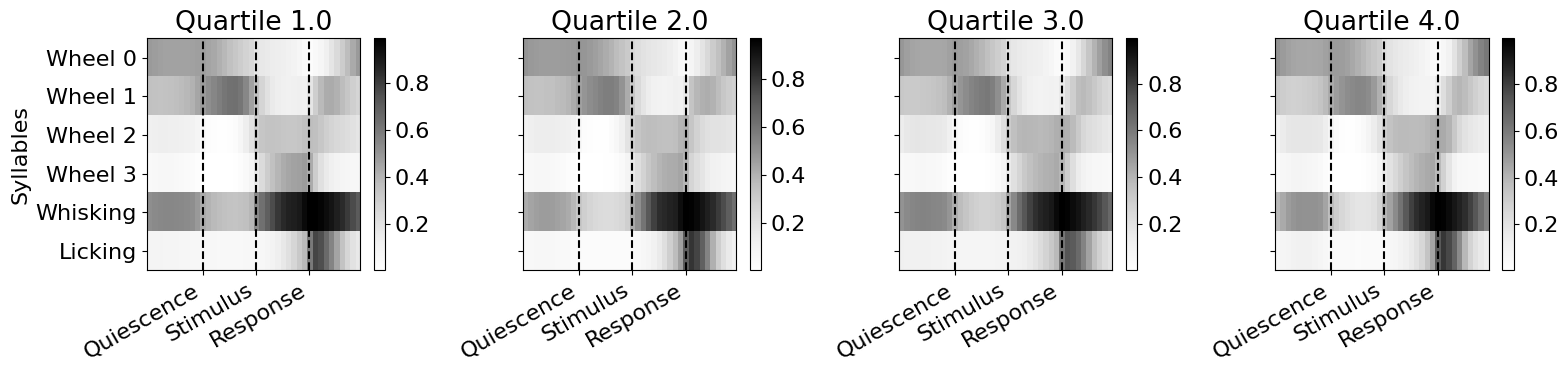

In [51]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)
# lick_states = replace_lick(use_sequences)
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, len(use_states['quartile'].unique()), sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()

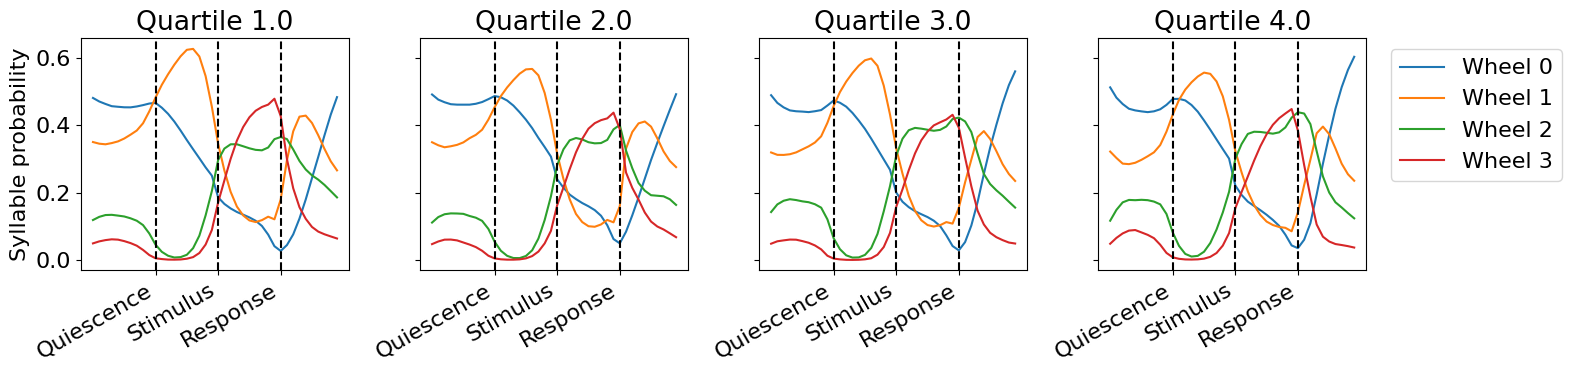

In [52]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllable probability')
plt.tight_layout()
plt.show()

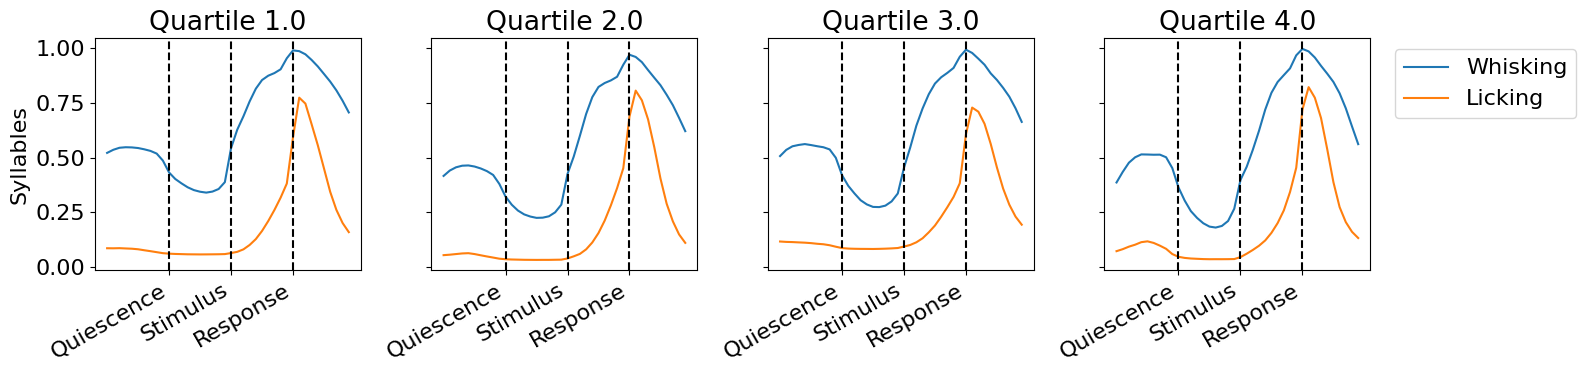

In [53]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[4:6, :].T, label=['Whisking', 'Licking'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()